<a href="https://colab.research.google.com/github/GulnazAleksashova/go-off/blob/main/Emotion_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion classifier


In [ ]:
import os 
import shutil
import librosa 
import numpy as np 
import matplotlib.pyplot as plt 
import time

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, \
                                    BatchNormalization, Flatten, Conv1D, Conv2D, LSTM 
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler 


In [ ]:
# The library for working with google disk
from google.colab import drive 
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
# Unzip the source database into the Google Colaboratory
!unzip -q '/content/drive/MyDrive/Базы/Emotion.zip' #распаковываем исходную базу в ноутбук колаба

In [ ]:
# Content of the source directory <TESS Toronto emotional speech set data>
!ls TESS\ Toronto\ emotional\ speech\ set\ data # \ - escapes spaces


OAF_angry    OAF_neutral	    YAF_disgust  YAF_pleasant_surprised
OAF_disgust  OAF_Pleasant_surprise  YAF_fear	 YAF_sad
OAF_Fear     OAF_Sad		    YAF_happy
OAF_happy    YAF_angry		    YAF_neutral


In [ ]:
# The list of all paths to existing files in the TESS folder
path = '/content/TESS Toronto emotional speech set data'
spisok = [] 
for adress, dirs, files in os.walk(path):
    for file in files:
        spisok.append(os.path.join(adress,file))
print(len(spisok))  

2800


In [ ]:
# Tranformation of the data set
# Create an empty emotion folder with 7 empty folders for each emotion
path = '/content'
dirname = 'emotion'
folders = ['fear', 
           'pleasant_surprise',
           'sad', 
           'angry', 
           'disgust', 
           'happy', 
           'neutral']

def createFolder(path):
    if not os.path.exists(path):
        os.mkdir(path)

fullPath = os.path.join(path,dirname)
createFolder(fullPath)
for f in folders:
    folder = os.path.join(fullPath,f)
    createFolder(folder)

In [ ]:
# Path way to each emotion
path_angry = '/content/emotion/angry'
path_disgust = '/content/emotion/disgust'
path_fear = '/content/emotion/fear'
path_happy = '/content/emotion/happy'
path_neutral = '/content/emotion/neutral'
path_pleasant_surprise = '/content/emotion/pleasant_surprise'
path_sad = '/content/emotion/sad'

In [ ]:
# Distribution of emotion audio files according to classes
for i in range(len(spisok)):
    path = spisok[i]
    if path.endswith('_angry.wav'):
        shutil.copy(path,path_angry)
    if path.endswith('_disgust.wav'):
        shutil.copy(path,path_disgust)
    if path.endswith('_fear.wav'):
        shutil.copy(path,path_fear)
    if path.endswith('_happy.wav'):
        shutil.copy(path,path_happy)
    if path.endswith('_neutral.wav'):
        shutil.copy(path,path_neutral)
    if path.endswith('_ps.wav'):
        shutil.copy(path,path_pleasant_surprise)
    if path.endswith('_sad.wav'):
        shutil.copy(path,path_sad) 
    

In [ ]:
# Example of counting number of files for current emotion
path, dirs, files = next(os.walk('/content/emotion/angry'))
file_count = len(files)
print(file_count)

400


In [ ]:
# Function of get features
def get_features(y, sr):
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) # Chroma frequency (default 12 color tanks)
    mfcc = librosa.feature.mfcc(y=y, sr=sr) # Mel-frequency cepstral coefficients (default 20)
  
    rmse = np.mean(librosa.feature.rms(y=y)) # Mean of root-mean-square (RMS) value for each frame
    spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) # Mean of spectral centroid
    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) # Mean of spectral bandwidth
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) # Mean of roll-off frequency
    zcr = np.mean(librosa.feature.zero_crossing_rate(y)) # Mean of zero-crossing rate of an audio time series
  
  
    # An empty list of audio parameters
    out = []  
    out.append(rmse) 
    out.append(spec_cent) 
    out.append(spec_bw) 
    out.append(rolloff) 
    out.append(zcr)  
  
    # Mean of all Mel-frequency cepstral coefficients (20 values)
    for e in mfcc:
        out.append(np.mean(e))

    # Mean of all Chroma frequency (12 values)
    for e in chroma_stft:
        out.append(np.mean(e))
  
    # List of parameters with dimension (37,)
    return out

In [ ]:
emotion = os.listdir('emotion')

In [ ]:
# Create a training set
X_train = []
Y_train = []

# Training set creation start time
curr_time = time.time()


for i in range(len(emotion)):
    e = emotion[i] # For each emotion
    for filename in os.listdir(f'./emotion/{e}'):
        # Get name of a file
        emotionName = f'./emotion/{e}/{filename}'
        # Use first 30 seconds of audio
        y, sr = librosa.load(emotionName, mono=True, duration=30) # y - audio time series dataset, 
                                                                  # sr - audio sample rate
        # Get parameters for training model
        out = get_features(y, sr)
    
        # X_train
        X_train.append(out)
        # Y_train in ohe format
        Y_train.append(to_categorical(i, len(emotion)))

    # Information about the readiness of database processing
    print('Emotion ', e, " is ready -> ", round(time.time() - curr_time), "sec", sep=" ")
    curr_time = time.time()

# Converting training set to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Emotion  fear  is ready ->  40 sec
Emotion  neutral  is ready ->  48 sec
Emotion  sad  is ready ->  54 sec
Emotion  happy  is ready ->  46 sec
Emotion  disgust  is ready ->  55 sec
Emotion  pleasant_surprise  is ready ->  47 sec
Emotion  angry  is ready ->  44 sec


In [ ]:
# Create backup of training set
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
# Number of classes
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 ... 6 6 6]


In [ ]:
# Shape of the training set
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(2800, 37)
(2800, 7)
(2800,)


In [ ]:
# Normalization of training set data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [ ]:
print(X_train[0])

[ 0.8138658   0.97365577  0.69244905  1.09360828  0.86253233  1.21936581
 -1.18607546 -1.39501369  0.76695095 -0.05291146 -0.40782365  0.27760923
  0.18008068 -0.74673401  0.57222089 -1.24486336 -0.14151916  1.03637773
 -1.35638962  0.55285374 -1.16238667 -0.80780705  1.70566379  0.22128142
  2.08989465  0.37427367 -0.37409173 -0.46103319 -0.47426506  0.7950521
 -0.21002796 -0.14810765 -0.00418789 -1.20099565 -1.23264485 -0.94619222
  0.30411963]


In [ ]:
# Split set to training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [ ]:
# Shape of training and test sets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2520, 37)
(2520,)
(280, 37)
(280,)


Epoch 1/200
126/126 [==============================] - 3s 17ms/step - loss: 0.2584 - accuracy: 0.9345 - val_loss: 0.0790 - val_accuracy: 0.9821
Epoch 2/200
126/126 [==============================] - 2s 16ms/step - loss: 0.0500 - accuracy: 0.9865 - val_loss: 0.0371 - val_accuracy: 0.9929
Epoch 3/200
126/126 [==============================] - 2s 16ms/step - loss: 0.0266 - accuracy: 0.9944 - val_loss: 0.0305 - val_accuracy: 0.9893
Epoch 4/200
126/126 [==============================] - 2s 16ms/step - loss: 0.0166 - accuracy: 0.9956 - val_loss: 0.0169 - val_accuracy: 0.9929
Epoch 5/200
126/126 [==============================] - 2s 16ms/step - loss: 0.0141 - accuracy: 0.9948 - val_loss: 0.0120 - val_accuracy: 0.9964
Epoch 6/200
126/126 [==============================] - 2s 15ms/step - loss: 0.0120 - accuracy: 0.9964 - val_loss: 0.0203 - val_accuracy: 0.9893
Epoch 7/200
126/126 [==============================] - 2s 16ms/step - loss: 0.0075 - accuracy: 0.9976 - val_loss: 0.0094 - val_accuracy:

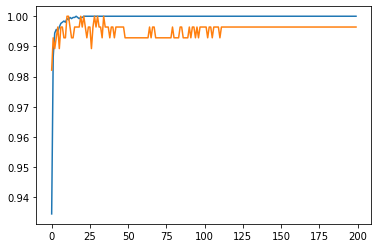

In [ ]:
# An architecture of neural network
# Indexes of input data
indexes = range(0,37)

model = Sequential()
model.add(Dense(1000, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(750, activation='elu'))
model.add(Dense(500, activation='elu'))
model.add(Dense(250, activation='elu'))
model.add(Dense(50, activation='elu'))

model.add(Dense(len(emotion), activation='softmax'))


model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

# Visualization of training process
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Emotion recognition


In [ ]:
# Choose audio file for recognition
emotionName = './emotion/disgust/OAF_bath_disgust.wav'
# An audio signal
y, sr = librosa.load(emotionName, mono=True, duration=30)
# Get parameters for training
out = get_features(y, sr)

In [ ]:
#Add dimension
out = np.array(out).reshape(1,37)

In [ ]:
out.shape

(1, 37)

In [ ]:
# Normalization of an audio signal
out = scaler.transform(out)

In [ ]:
# Print normalized vector of an audio signal parameters
print(out)

[[-0.78812167 -0.8804883  -0.63740302 -1.09833144 -0.7801011  -0.58608994
   1.18663211 -0.22687767 -1.24541541  1.49711351  0.7998436  -0.57327838
   1.5406303  -0.23039576  1.28751113  0.99405709 -0.00942911  0.7238642
  -0.23132915  0.62477886  1.25249576 -1.35984261 -0.01627598  0.56938522
  -0.70297919  0.8243902   0.21228304  0.23189011  0.68515429  1.70354949
   1.31561082 -0.05419634  0.06265963  0.72902043  0.5288528   0.45284728
   1.33297293]]


In [ ]:
# Prediction
y = model.predict(out)

In [ ]:
# Print results of prediction
print('Result of prediction', y)
print('Index of predicted class of emotion', np.argmax(y))
print('Actual index of current emotion', emotion.index('disgust'))

Result of prediction [[1.2162045e-17 6.2462285e-15 8.7206955e-15 1.7915042e-26 1.0000000e+00
  1.2239111e-18 7.0387549e-15]]
Index of predicted class of emotion 4
Actual index of current emotion 4
